<a href="https://colab.research.google.com/github/sastrawanikadek/bangkit-assignment-5-face-recognition-CNN/blob/master/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Configuration

In [0]:
from matplotlib import pyplot as plt
import os
import numpy as np
%matplotlib inline

BASE_DIR = os.path.join(os.getcwd(), "drive", "My Drive", "VGG FACE 2")
CLASSES = os.listdir(BASE_DIR)
CLASS_TOTAL = len(CLASSES)
EPOCH = 40
BATCH_SIZE = 5
SIZE = (96, 96)
LEARNING_RATE = 0.00005
BRIGHTNESS = 1.2

print("CLASS TOTAL: ", CLASS_TOTAL)

CLASS TOTAL:  200


# Helpers

In [0]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import ImageEnhance 
import numpy as np
import itertools


def preprocessing(path):
  img = load_img(path, target_size=SIZE, color_mode="grayscale")
  enhancer = ImageEnhance.Brightness(img)
  img = enhancer.enhance(BRIGHTNESS)
  img_array = img_to_array(img)
  img_array = np.dstack([img_array] * 3)
  return img_array

# Load and Preprocessing

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import random

X_train = []
X_val = []
X_test = []
Y_train = []
Y_val = []
Y_test = []

for index, className in enumerate(CLASSES):
  files = os.listdir(os.path.join(BASE_DIR, className))
  
  if len(files) >= 100:
    files = files[:100]
    train_x, test_x, train_y, test_y = train_test_split(files, 
                                                        [index] * len(files), 
                                                        test_size=10/100, 
                                                        random_state=42)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                                                      test_size=10/90, 
                                                      random_state=42)
  
    for filename in train_x:
      img_array = preprocessing(os.path.join(BASE_DIR, className, filename))
      X_train.append(img_array)
    
    for filename in val_x:
      img_array = preprocessing(os.path.join(BASE_DIR, className, filename))
      X_val.append(img_array)

    for filename in test_x:
      img_array = preprocessing(os.path.join(BASE_DIR, className, filename))
      X_test.append(img_array)

    Y_train.extend(train_y)
    Y_val.extend(val_y)
    Y_test.extend(test_y)

mapListTrain = list(zip(X_train, Y_train))
random.shuffle(mapListTrain)
X_train, Y_train = zip(*mapListTrain)
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = to_categorical(np.array(Y_train))
Y_val = to_categorical(np.array(Y_val))
Y_test = to_categorical(np.array(Y_test))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(16000, 96, 96, 3)
(2000, 96, 96, 3)
(2000, 96, 96, 3)
(16000, 200)
(2000, 200)
(2000, 200)


# Show Sample Images

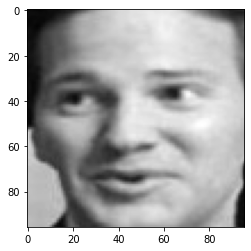

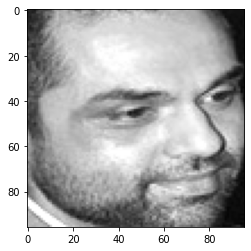

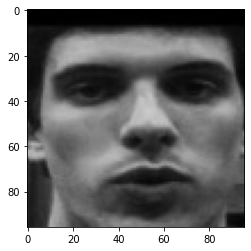

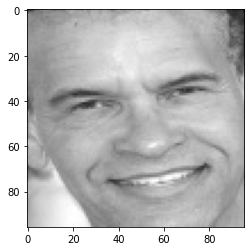

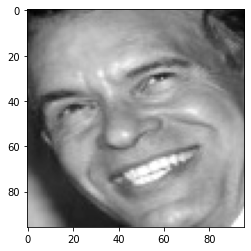

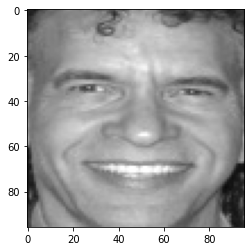

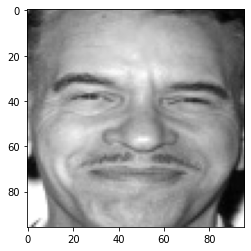

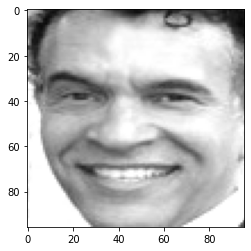

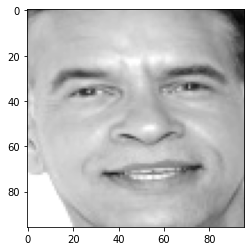

In [0]:
plt.imshow(X_train[0].astype(np.uint8))
plt.show()
plt.imshow(X_train[1].astype(np.uint8))
plt.show()
plt.imshow(X_train[2].astype(np.uint8))
plt.show()
plt.imshow(X_val[0].astype(np.uint8))
plt.show()
plt.imshow(X_val[1].astype(np.uint8))
plt.show()
plt.imshow(X_val[2].astype(np.uint8))
plt.show()
plt.imshow(X_test[0].astype(np.uint8))
plt.show()
plt.imshow(X_test[1].astype(np.uint8))
plt.show()
plt.imshow(X_test[2].astype(np.uint8))
plt.show()

# Create Model

In [0]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

def create_model():
  clear_session()

  base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg",
                          input_shape=(96, 96, 3))
  x = base_model.output
  x = Dropout(0.3)(x)
  classifier = Dense(CLASS_TOTAL, activation="softmax")(x)
  model = Model(inputs=base_model.input, outputs=classifier)
  model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=LEARNING_RATE), metrics=["accuracy"])
  return model

# Train Model

In [0]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.backend import clear_session

clear_session()
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

model = create_model()
history = model.fit(X_train, Y_train, epochs=EPOCH, 
                    validation_data=(X_val, Y_val), batch_size=BATCH_SIZE)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], ls="--")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], ls="--")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

NameError: ignored

# Test Model

In [0]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

X_test = preprocess_input(X_test)

evaluation = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
prediction = model.predict(X_test, batch_size=BATCH_SIZE)
prediction_classes = prediction.argmax(axis=-1)
cm = confusion_matrix(Y_test.argmax(axis=-1), prediction_classes)
cm_plot_labels = [num + 1 for num in range(CLASS_TOTAL)]

f1 = f1_score(Y_test.argmax(axis=-1), prediction_classes, average="macro")
precision = precision_score(Y_test.argmax(axis=-1), prediction_classes, average="macro")
recall = recall_score(Y_test.argmax(axis=-1), prediction_classes, average="macro")

print("FINAL EVALUATION:")
print("loss " + str(evaluation[0]))
print("acc " + str(evaluation[1]))
print("f1 " + str(f1))
print("precision " + str(precision))
print("recall " + str(recall))

# Save Model

In [0]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

file = open('model.tflite' , 'wb') 
file.write(tflite_model)